<a href="https://colab.research.google.com/github/LucasMirachi/portfolio/blob/master/Placas_de_transito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reconhecimento de placas de trânsito**

In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [ ]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

sns.set()

In [ ]:
np.random.seed(0)

# **IMAGE PRE-PROCESSING**

In [ ]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
  
print(type(train_data))

X_train, y_train = train_data['features'], train_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
X_val, y_val = val_data['features'], val_data['labels']

<class 'dict'>


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [ ]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32, 32, 3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32, 32, 3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32, 32, 3"

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

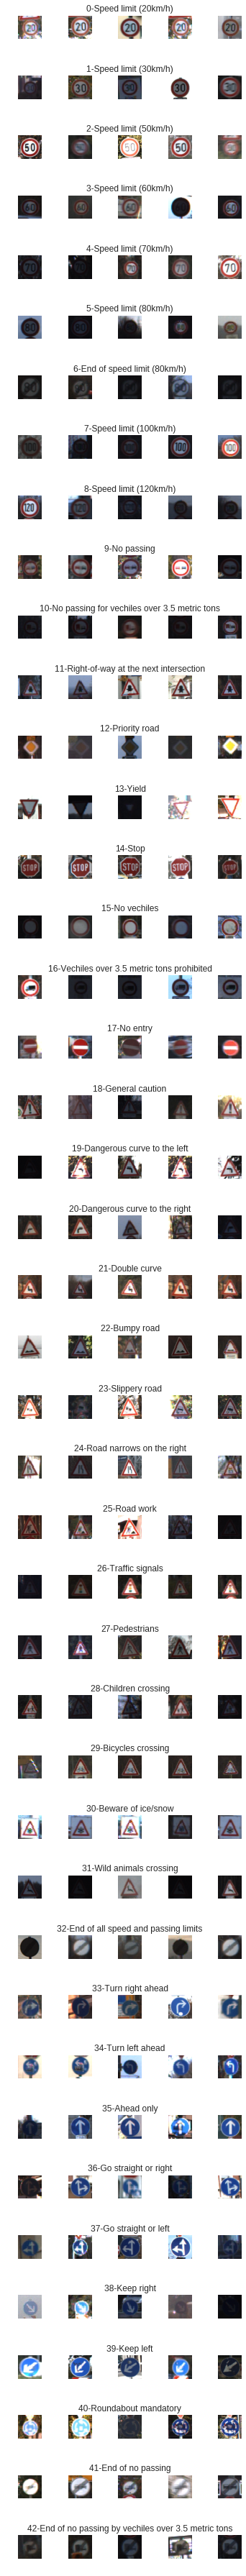

In [ ]:
num_of_samples=[]

cols = 5
num_classes = 43

fig, axs =  plt.subplots(nrows = num_classes, ncols = cols, figsize = (5,50))
fig.tight_layout()

for i in range(cols):
  for j, row in data.iterrows():
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
    axs[j][i].axis('off')
    if i == 2:
      axs[j][i].set_title(str(j) + '-' + row["SignName"])
      num_of_samples.append(len(x_selected))
    

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


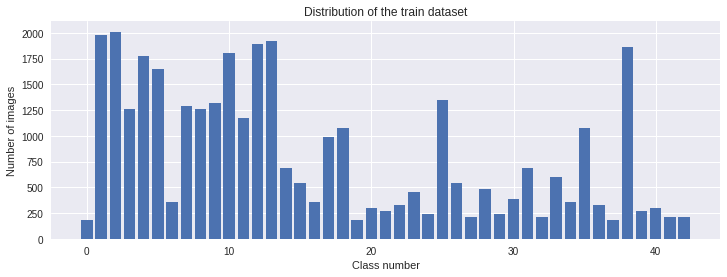

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title('Distribution of the train dataset')
plt.xlabel('Class number')
plt.ylabel('Number of images')
plt.show()

(32, 32, 3)
41


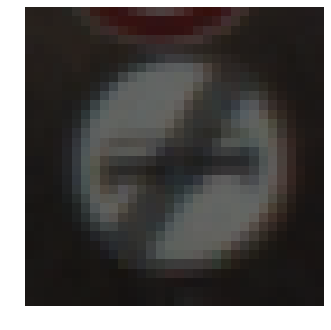

In [ ]:
import cv2

plt.imshow(X_train[19])
plt.axis('off')
print(X_train[19].shape)
print(y_train[19])

(32, 32)


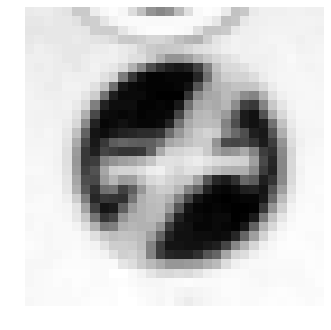

In [ ]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[19])
plt.imshow(img)
plt.axis('off')
print(img.shape)

(32, 32)


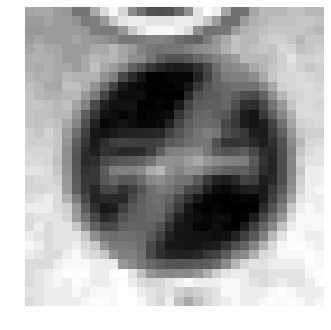

In [ ]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img)
plt.axis('off')
print(img.shape)

In [ ]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


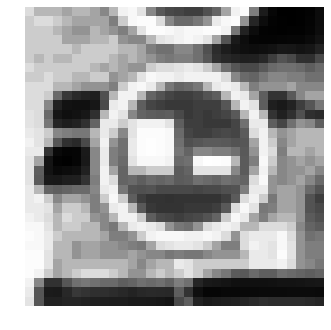

In [ ]:
plt.imshow(X_train[random.randint(0,  len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [ ]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

Fazendo a transformação dos dados para tornar o treinamento muito mais eficaz

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             zoom_range = 0.2,
                             shear_range = 0.1,
                             rotation_range = 10)
datagen.fit(X_train)

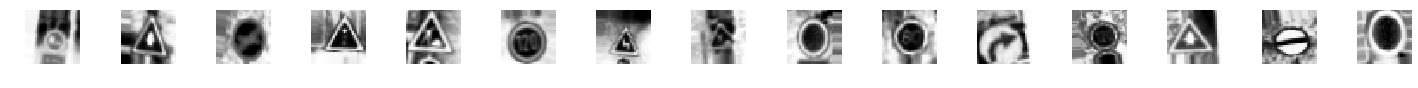

In [ ]:
batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis('off')

In [ ]:

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [ ]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

# **CONSTRUÇÃO DO MODELO** 

In [ ]:
def leNet_model():
  model = Sequential()
  model.add(Conv2D(30, (5, 5), input_shape=(32, 32, 1), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Conv2D(15, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Flatten())
  model.add(Dense(500, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax'))
  
  #Compile Model
  model.compile(Adam(lr = 0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
model = leNet_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 28, 28, 30)        780       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 30)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 12, 12, 15)        4065      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 6, 6, 15)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 540)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 500)               270500    
_________________________________________________________________
dropout_11 (Dropout)         (None, 500)               0         
__________

In [ ]:
history = model.fit(X_train, y_train, epochs = 10, validation_data = (X_val, y_val), batch_size = 400, verbose = 1, shuffle = 1)

Train on 34799 samples, validate on 4410 samples
Epoch 1/10
34799/34799 [==============================] - 3s 79us/step - loss: 3.0488 - acc: 0.1703 - val_loss: 1.5834 - val_acc: 0.5132
Epoch 2/10
34799/34799 [==============================] - 2s 49us/step - loss: 1.0120 - acc: 0.6767 - val_loss: 0.6794 - val_acc: 0.7959
Epoch 3/10
34799/34799 [==============================] - 2s 49us/step - loss: 0.5625 - acc: 0.8179 - val_loss: 0.4731 - val_acc: 0.8565
Epoch 4/10
34799/34799 [==============================] - 2s 49us/step - loss: 0.4306 - acc: 0.8615 - val_loss: 0.5039 - val_acc: 0.8621
Epoch 5/10
34799/34799 [==============================] - 2s 48us/step - loss: 0.3647 - acc: 0.8815 - val_loss: 0.4459 - val_acc: 0.8807
Epoch 6/10
34799/34799 [==============================] - 2s 48us/step - loss: 0.3348 - acc: 0.8886 - val_loss: 0.4427 - val_acc: 0.8841
Epoch 7/10
34799/34799 [==============================] - 2s 48us/step - loss: 0.2730 - acc: 0.9107 - val_loss: 0.3879 - val_acc:

Text(0.5,0,'epoch')

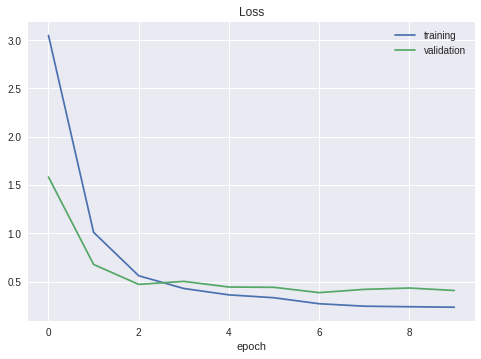

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5,0,'epoch')

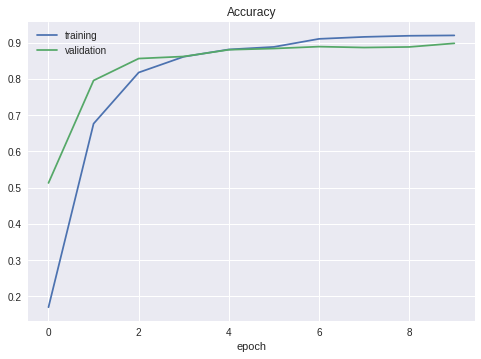

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.5012290260098987
Test Accuracy: 0.8746634995946786


**Devido ao fato de que não obtive bons resultados, a modificação da rede neural será feita, adicionando mais layers, diminuindo o learning rate e aumentando o número de filtros**

In [ ]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation = 'relu'))
  model.add(Conv2D(60, (5, 5), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  
  model.add(Conv2D(30, (3, 3), activation = 'relu'))
  model.add(Conv2D(30, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax'))
  
  #Compile Model
  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
model = modified_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 480)               0         
__________

In [ ]:
history = model.fit(X_train, y_train, epochs = 10, validation_data = (X_val, y_val), batch_size = 400, verbose = 1, shuffle = 1)

Train on 34799 samples, validate on 4410 samples
Epoch 1/10
34799/34799 [==============================] - 6s 181us/step - loss: 2.0846 - acc: 0.4394 - val_loss: 0.5135 - val_acc: 0.8526
Epoch 2/10
34799/34799 [==============================] - 5s 149us/step - loss: 0.3869 - acc: 0.8824 - val_loss: 0.2596 - val_acc: 0.9181
Epoch 3/10
34799/34799 [==============================] - 5s 148us/step - loss: 0.1867 - acc: 0.9440 - val_loss: 0.2037 - val_acc: 0.9404
Epoch 4/10
34799/34799 [==============================] - 5s 148us/step - loss: 0.1266 - acc: 0.9622 - val_loss: 0.1541 - val_acc: 0.9533
Epoch 5/10
34799/34799 [==============================] - 5s 148us/step - loss: 0.0838 - acc: 0.9743 - val_loss: 0.1537 - val_acc: 0.9585
Epoch 6/10
34799/34799 [==============================] - 5s 148us/step - loss: 0.0667 - acc: 0.9797 - val_loss: 0.1225 - val_acc: 0.9612
Epoch 7/10
34799/34799 [==============================] - 5s 148us/step - loss: 0.0565 - acc: 0.9820 - val_loss: 0.1099 - v

Text(0.5,0,'epoch')

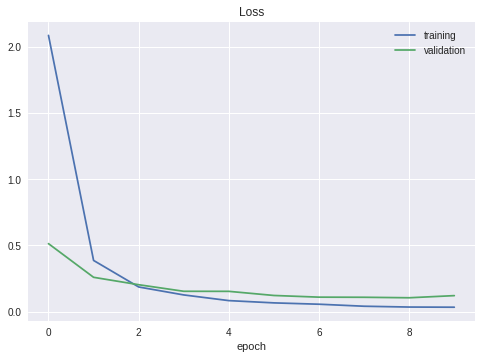

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5,0,'epoch')

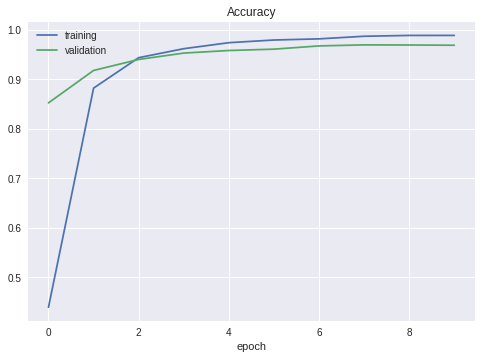

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.23784133569873508
Test Accuracy: 0.9457640538589405


**Aqui, pode-se notar que agora o valor da accuracy está bem melhor mas, observando os plots, pode-se notar que o modelo ainda está tendo overfit, já que a validation accuracy estão abaixo dos valores do training.**

***Um jeito bastante eficiente de reduzir o overfitting é adicionando mais uma Dropout Layer!***

In [ ]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation = 'relu'))
  model.add(Conv2D(60, (5, 5), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  
  model.add(Conv2D(30, (3, 3), activation = 'relu'))
  model.add(Conv2D(30, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  #model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(500, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax'))
  
  #Compile Model
  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
model = modified_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 480)               0         
__________

In [ ]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 50), steps_per_epoch = 2000, epochs = 10, validation_data = (X_val, y_val), shuffle = 1)

Epoch 1/10
2000/2000 [==============================] - 57s 29ms/step - loss: 0.8900 - acc: 0.7410 - val_loss: 0.1235 - val_acc: 0.9673
Epoch 2/10
2000/2000 [==============================] - 55s 28ms/step - loss: 0.2281 - acc: 0.9289 - val_loss: 0.0599 - val_acc: 0.9794
Epoch 3/10
2000/2000 [==============================] - 56s 28ms/step - loss: 0.1504 - acc: 0.9536 - val_loss: 0.0404 - val_acc: 0.9875
Epoch 4/10
2000/2000 [==============================] - 56s 28ms/step - loss: 0.1172 - acc: 0.9644 - val_loss: 0.0333 - val_acc: 0.9891
Epoch 5/10
2000/2000 [==============================] - 56s 28ms/step - loss: 0.0983 - acc: 0.9699 - val_loss: 0.0303 - val_acc: 0.9912
Epoch 6/10
2000/2000 [==============================] - 56s 28ms/step - loss: 0.0850 - acc: 0.9737 - val_loss: 0.0240 - val_acc: 0.9921
Epoch 7/10
2000/2000 [==============================] - 56s 28ms/step - loss: 0.0754 - acc: 0.9766 - val_loss: 0.0310 - val_acc: 0.9902
Epoch 8/10
2000/2000 [==========================

Text(0.5,0,'epoch')

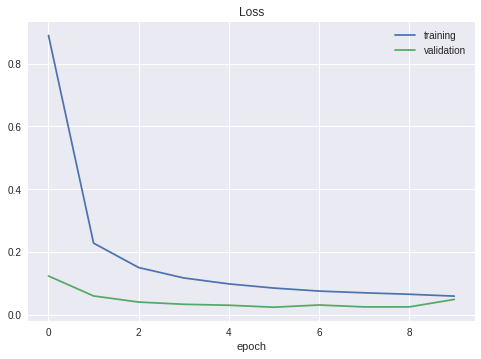

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5,0,'epoch')

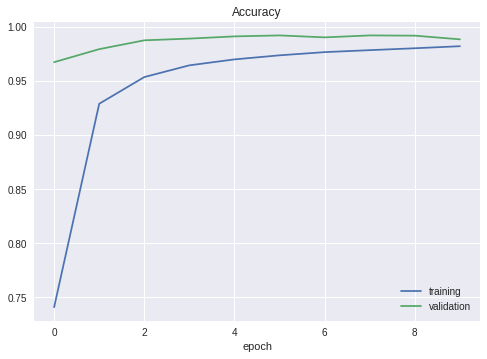

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.10829531287784974
Test Accuracy: 0.97505938244168


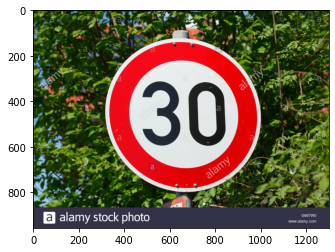

In [ ]:
#Carregando a imagem

import matplotlib.pyplot as plt 
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


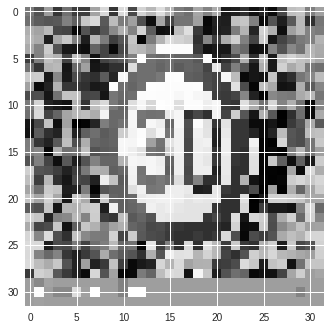

In [ ]:
#Processando a imagem
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [ ]:
#Fazendo um reshape
 
img = img.reshape(1, 32, 32, 1)

In [ ]:
#Testando a imagem

print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [1]


In [ ]:
#Outras imagens para testar!
#https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg
#https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg
#https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg
#https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg